In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import itertools
import random
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve, average_precision_score
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models, metrics
from keras.models import load_model

from tensorflow.keras.applications import InceptionV3

from plot_utils import *

2024-05-18 15:14:42.260847: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 1. Train-validation split

In [3]:
df_all = pd.read_csv('Dataset/processed/chest_xray_images_properties.csv')
df_all.head()

,path,label,dataset,max,min,mean,std,height,width
0,Dataset/chest_xray/train/NORMAL/NORMAL2-IM-092...,NORMAL,train,255,0,124.391030,56.330762,2234,2359
1,Dataset/chest_xray/train/NORMAL/NORMAL2-IM-105...,NORMAL,train,255,0,115.710751,56.844688,1067,1422
2,Dataset/chest_xray/train/NORMAL/IM-0427-0001.jpeg,NORMAL,train,255,0,133.991183,65.503709,1357,1828
3,Dataset/chest_xray/train/NORMAL/NORMAL2-IM-126...,NORMAL,train,255,0,111.488999,68.965235,1495,1854
4,Dataset/chest_xray/train/NORMAL/IM-0656-0001-0...,NORMAL,train,255,0,148.148118,60.029570,1966,2194


With only 16 samples in the original validation set, it might not provide a robust estimate of model performance.

I need to create a new validation set by stratifying the training data into training and validation sets with an 80:20 train/validation ratio. This stratification ensures that samples are evenly distributed based on classes, which helps achieve more consistent prediction performance.

In [4]:
train_val_df = df_all[(df_all['dataset'] == 'train') | (df_all['dataset'] == 'val')]
valid_size = 0.2
train_df, val_df = train_test_split(train_val_df, test_size=0.2, stratify=train_val_df['label'], random_state=42)
train_df['dataset'] = 'train'
val_df['dataset'] = 'val'

test_df = df_all[df_all['dataset'] == 'test']

print("Before:")
print("Train:", len(df_all[df_all['dataset'] == 'train']))
print("Val:", len(df_all[df_all['dataset'] == 'val']))
print("------\nAfter:")
print("Train:", len(train_df))
print("Val:", len(val_df))

print("\nTest:", len(test_df))


Before:
Train: 5216
Val: 16
------
After:
Train: 4185
Val: 1047

Test: 624


# 2. Image transformations

Image transformations are preprocessing steps applied to images before feeding them into a Convolutional Neural Network (CNN). These transformations serve multiple purposes to enhance the performance and robustness of the CNN:
- **Resize:** the images in the dataset don't have same dimensions, but CNNs typically expect inputs of consistent dimensions. Therefore, resizing ensures that all images are brought to a uniform size, making them compatible with the CNN architecture.

- **Image Augmentation:** Augmentations like random rotation, flipping, zooming, or shifting are applied to introduce variations in the training data. This helps prevent overfitting by exposing the model to a wider range of possible inputs, mimicking real-world scenarios where images can have different orientations or positions. However, I will not apply transformations such as flips and big rotations because X-ray scans are only taken in a specific orientation and this variations don't exist in real X-ray images  

- **Normalization:** Pixel values in images usually range from 0 to 255 for each color channel (red, green, blue). Normalization scales these pixel values to a standardized range, such as [-1, 1] or [0, 1]. This makes the data more amenable to optimization algorithms, as gradients are more consistent across features and convergence is faster.

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=5, # Rotate images by a maximum of 5 degrees
    width_shift_range=0.1, # Shift images horizontally by 10% of the width
    height_shift_range=0.1, # Shift images horizontally by 10% of the height
    zoom_range=0.2, # Zoom in/out by 20%
    fill_mode='nearest',
)

val_datagen = ImageDataGenerator(rescale=1.0/255)

test_datagen = ImageDataGenerator(rescale=1.0/255)

img_size = (224, 224)
batch_size = 64 # 32, 64, 128

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle = True,
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='path',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle = False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False
)

Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


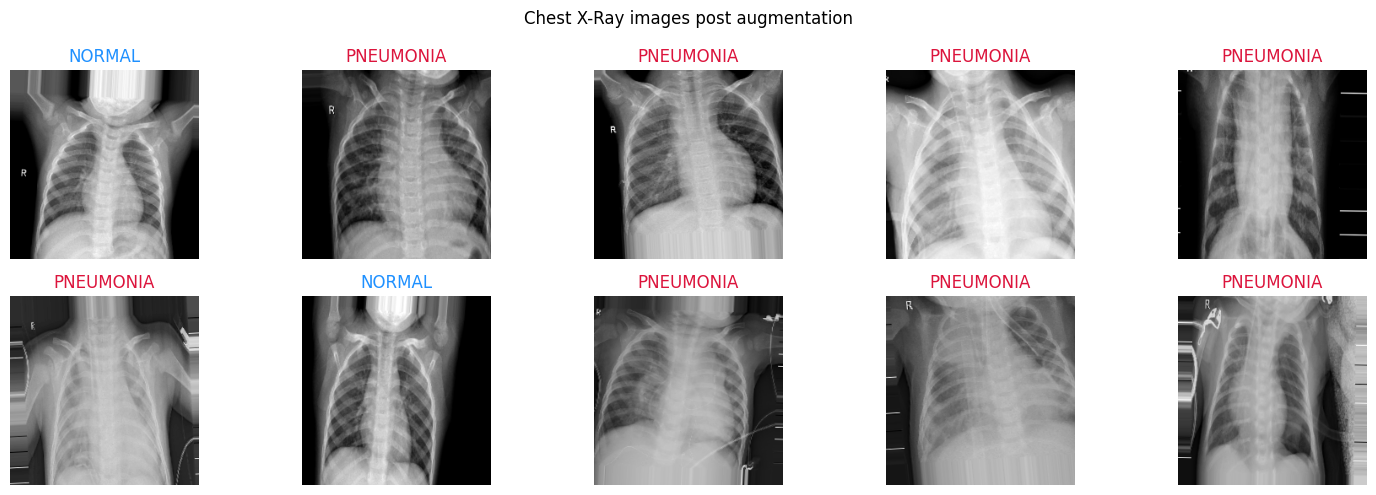

In [6]:
images, labels = next(train_generator)
class_indices = train_generator.class_indices

plot_images(images, labels, class_indices, num_images=10)

# 3. Image classification using CNN

## 3.1 Build the CNN

- I will start with a simpler CNN architecture to establish a baseline model.
- I chose Adam for its adaptive learning rates and efficiency, and categorical cross-entropy for its suitability in binary classification with probabilistic interpretation and smooth optimization.
- Since the dataset is imbalanced, with more images of the PNEUMONIA class compared to the NORMAL class, I will use class weights to address this issue.
- Additionally, I will evaluate the model using multiple metrics to gain a comprehensive understanding of the model's performance.



In [10]:
model = models.Sequential([
    layers.Input(shape=(224, 224, 1)),

    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    
    layers.Dense(2, activation='softmax')
])

model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 224, 224, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,308,802 (12.62 MB)

 Trainable params: 3,308,802 (12.62 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model = models.Sequential([
    layers.Input(shape=(224, 224, 1)),

    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(2, activation='softmax')
])

model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 224, 224, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 224, 224, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 112, 112, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,138,674 (50.12 MB)

 Trainable params: 13,138,674 (50.12 MB)

 Non-trainable params: 0 (0.00 B)

## 3.2 Calculate class weights

In [12]:
count_normal = len(train_df[train_df['label'] == 'NORMAL'])
count_pneumonia = len(train_df[train_df['label'] == 'PNEUMONIA'])
count_total = len(train_df)

# Scaling by total/2 helps keep the loss to a similar magnitude - the sum of the weights of all examples stays the same.
weight_for_0 = (1 / count_normal) * (count_total / 2.0)
weight_for_1 = (1 / count_pneumonia) * (count_total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.94
Weight for class 1: 0.67


The weight for class 0 (Normal) is higher than that for class 1 (Pneumonia) because there are more normal images in the dataset.

This weight adjustment ensures that each normal image contributes proportionally to training, helping to balance the dataset for better performance of the CNN.

## 3.3 Train CNN model

I use the early stop callback to stop training when the model's performance on the validation set stops improving. This approach avoids overfitting and ensures efficient use of resources.

In [43]:
checkpoint_path = "Models/CNN_callback/best_model.keras"

checkpoint_callback = ModelCheckpoint(checkpoint_path, 
                                      monitor='val_loss', 
                                      save_best_only=True)

early_stopping_callback = EarlyStopping(monitor='val_loss', 
                                        patience=5)

In [ ]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    class_weight=class_weight,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

In [47]:
model.save(f'Models/CNN/cnn_model.keras')
print('Model saved!')

with open('Models/CNN/training_history.pkl', 'wb') as file:
    pickle.dump(history, file)

Model saved!


## 3.4 Visualize the loss and accuracy curves

In [13]:
model = tf.keras.models.load_model('Models/CNN/model1/cnn_model.keras')

with open('Models/CNN/model1/training_history.pkl', 'rb') as file:
    history = pickle.load(file)

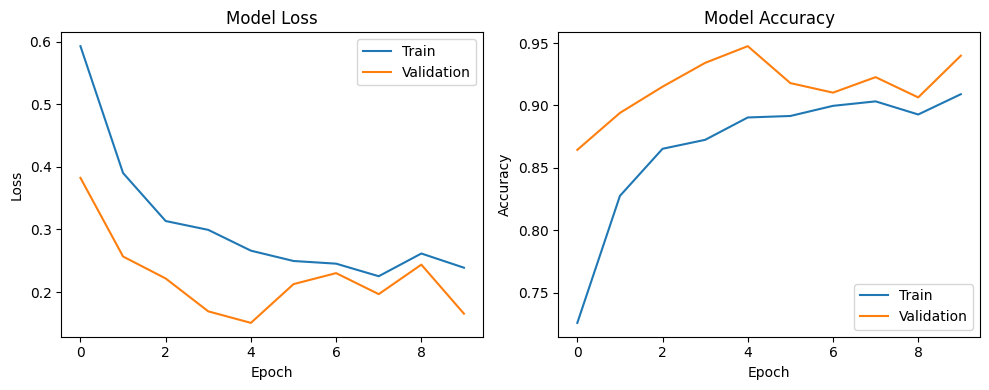

In [18]:
plot_training_history(history)

## 3.5 Make predictions on test dataset

In [19]:
test_loss, test_accuracy = model.evaluate(test_generator)
predictions = model.predict(test_generator)

y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes
y_probs = predictions[:, 1]

print(f'\nTest Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 530ms/step - accuracy: 0.8357 - loss: 0.5541
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 485ms/step

Test Loss: 0.3905
Test Accuracy: 0.8782


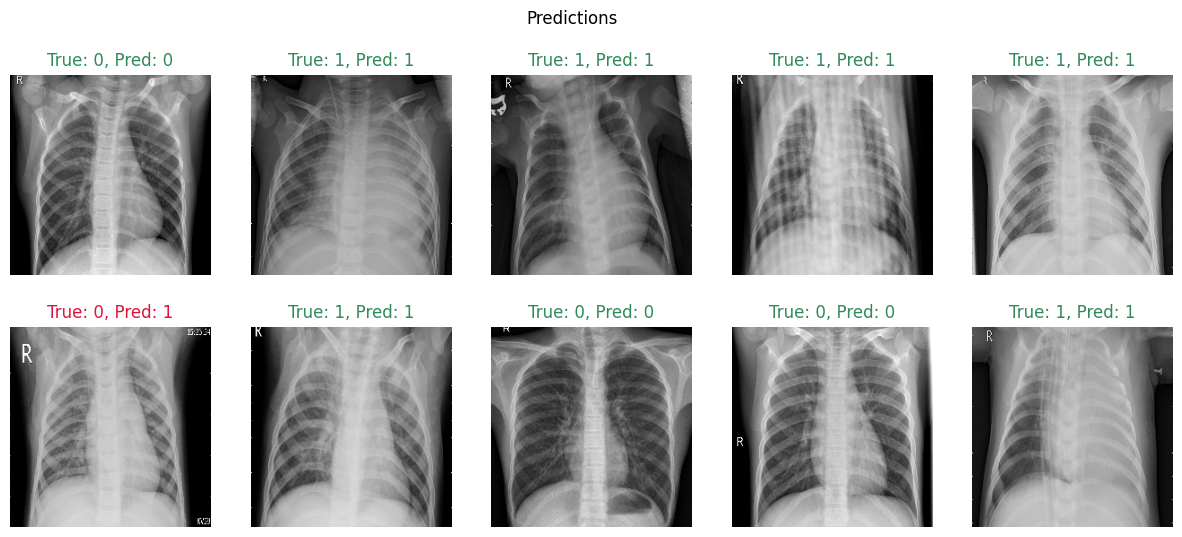

In [55]:
plot_predictions(test_generator, y_true, y_pred, num_images=10)

## 3.6 Evaluate results on test set


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.76      0.82       234
           1       0.87      0.95      0.91       390

    accuracy                           0.88       624
   macro avg       0.88      0.85      0.87       624
weighted avg       0.88      0.88      0.88       624


Evaluation scores:
Accuracy: 0.8782
Precision: 0.8685
Recall: 0.9487
F1-Score: 0.9069

Confusion matrix:


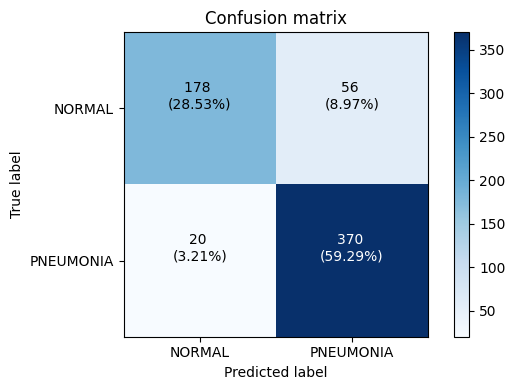

In [56]:
print('\nClassification Report:')
report = classification_report(y_true, y_pred, target_names=[str(i) for i in range(len(test_generator.class_indices))])
print(report)

print('\nEvaluation scores:')
print_evaluation_scores(y_true, y_pred)

print('\nConfusion matrix:')
cm = confusion_matrix(y_true, y_pred)
classes = list(test_generator.class_indices.keys())
plot_confusion_matrix(cm, classes)

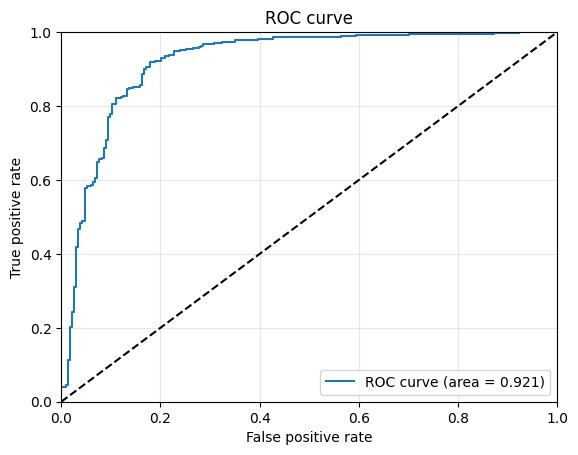

In [58]:
plot_roc_curve(y_true, y_probs)

Overall, these metrics suggest that the model performs relatively well in classifying NORMAL/PNEUMONIA cases.

The high recall suggests that the model is adept at capturing almost all instances of pneumonia, minimizing false negatives (pneumonia cases incorrectly classified as normal). However, the precision being slightly lower indicates that there are some false positives (normal cases incorrectly classified as pneumonia).